In [1]:
import pyvista

pyvista.global_theme.trame.server_proxy_enabled = True
pyvista.start_xvfb()

In [2]:
import jax

jax.config.update("jax_compilation_cache_dir", "./jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools

In [3]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle, ellipse
import itertools
from matplotlib.gridspec import GridSpec

In [4]:
import sys

sys.path.append("../fft_helpers/")

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from fft_operators import laplacian_operator, gradient_operator
from custom_solvers import conjugate_gradient

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])

from plot_helper_for_paper import set_size, plot_imshow, plot_contourf

In [5]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)

In [6]:
def test_microstructure(N, operator):
    H, L = (N, N)
    Hmid = int(H / 2)
    Lmid = int(L / 2)
    r = int(H / 2)

    structure = np.zeros((H, L))
    structure[:r, -r:] += rectangle(r, r)
    structure = np.flipud(structure)
    structure = np.fliplr(structure)

    ndim = len(structure.shape)
    N = structure.shape[0]
    shape = [
        N,
    ] * ndim

    # identity tensor (single tensor)
    i = jnp.eye(ndim)

    # identity tensors (grid)
    I2 = jnp.einsum(
        "ij,xy",
        i,
        jnp.ones(
            [
                N,
            ]
            * ndim
        ),
    )
    I = jnp.einsum(
        "ij,xy",
        i,
        jnp.ones(
            [
                N,
            ]
            * ndim
        ),
    )
    I4 = jnp.einsum(
        "ijkl,xy->ijklxy",
        jnp.einsum("il,jk", i, i),
        jnp.ones(
            [
                N,
            ]
            * ndim
        ),
    )
    I4rt = jnp.einsum(
        "ijkl,xy->ijklxy",
        jnp.einsum("ik,jl", i, i),
        jnp.ones(
            [
                N,
            ]
            * ndim
        ),
    )

    I4s = (I4 + I4rt) / 2.0
    II = tensor.dyad22(I, I)
    I4d = I4s - II / 3.0

    # material parameters
    phase_contrast = 1000.0

    # lames constant
    lambda_modulus = {"soft": 1.0, "hard": phase_contrast}
    shear_modulus = {"soft": 1.0, "hard": phase_contrast}

    bulk_modulus = {}
    bulk_modulus["soft"] = lambda_modulus["soft"] + 2 * shear_modulus["soft"] / 3
    bulk_modulus["hard"] = lambda_modulus["hard"] + 2 * shear_modulus["hard"] / 3

    # material parameters
    K = param(
        structure, soft=bulk_modulus["soft"], hard=bulk_modulus["hard"]
    )  # bulk      modulus
    μ0 = param(
        structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
    )  # shear     modulus
    λ0 = param(
        structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
    )  # shear     modulus

    @jax.jit
    def strain_energy(eps):
        eps_sym = 0.5 * (eps + tensor.trans2(eps))
        energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym) ** 2) + jnp.multiply(
            μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym))
        )
        return energy.sum()

    sigma = jax.jit(jax.jacrev(strain_energy))

    # (inverse) Fourier transform (for each tensor component in each direction)
    @jax.jit
    def fft(x):
        return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))

    @jax.jit
    def ifft(x):
        return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

    Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator=operator, length=1.0)

    # functions for the projection 'G', and the product 'G : K : eps'
    @jax.jit
    def G(A2):
        return jnp.real(ifft(tensor.ddot42(Ghat4_2, fft(A2)))).reshape(-1)

    @jax.jit
    def G_K_deps(depsm, additionals):
        depsm = depsm.reshape(ndim, ndim, N, N)
        return G(sigma(depsm))

    @jax.jit
    def solve_elasticity(state, n):
        dF, b, F, Fn = state

        error = jnp.linalg.norm(dF) / Fn
        jax.debug.print("residual={}", error)

        def true_fun(state):
            dF, b, F, Fn = state

            dF, iiter = conjugate_gradient(
                atol=1e-10, A=G_K_deps, b=b, additional=None
            )  # solve linear system using CG

            dF = dF.reshape(ndim, ndim, N, N)
            F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
            P = sigma(F)  # new residual stress
            b = -G_K_deps(F, None)  # compute residual

            return (dF, b, F, Fn)

        def false_fun(state):
            return state

        return jax.lax.cond(error > 1e-10, true_fun, false_fun, state), n

    sig = jnp.zeros([ndim, ndim, N, N])
    eps = jnp.zeros([ndim, ndim, N, N])

    deps = jnp.zeros([ndim, ndim, N, N])
    deps = deps.at[0, 1].set(5e-1)
    deps = deps.at[1, 0].set(5e-1)

    # initial residual: distribute "DE" over grid using "K4"
    b = -G_K_deps(deps, None)
    eps = jax.lax.add(eps, deps)
    En = jnp.linalg.norm(eps)

    state = (deps, b, eps, En)
    state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_elasticity, init=state, xs=jnp.arange(0, 20))
    sig = sigma(final_state[2])

    return sig.at[0, 1].get(), structure

In [7]:
N = 699
sig_xy, structure = test_microstructure(N=N, operator="rotated")

residual=1.0
residual=1.6888413844797778
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13
residual=2.686989114057965e-13


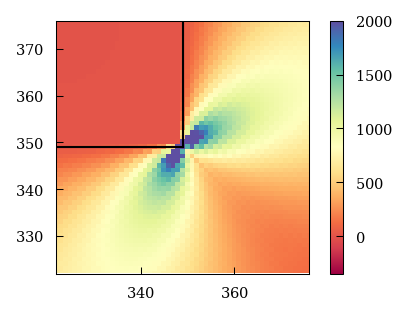

In [8]:
length = 1
dx = length / N
N_inset = int(0.04 / dx)

plt.imshow(sig_xy, origin="lower", cmap="Spectral", vmax=2000)
plt.xlim(int(N / 2) - N_inset, int(N / 2) + N_inset)
plt.ylim(int(N / 2) - N_inset, int(N / 2) + N_inset)
plt.plot(
    [int(N / 2) - N_inset, int(N / 2)], [int(N / 2), int(N / 2)], color="k", zorder=20
)
plt.plot(
    [int(N / 2), int(N / 2)],
    [int(N / 2), int(N / 2) + N_inset],
    color="k",
    zorder=20,
)

plt.colorbar()

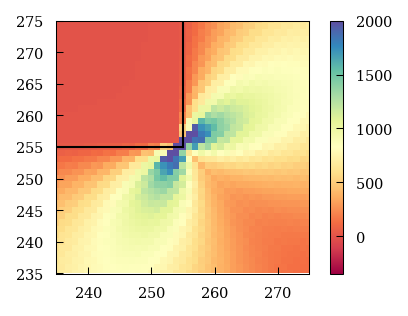

In [68]:
length = 1
dx = length / N
N_inset = int(0.04 / dx)

plt.imshow(sig_xy, origin="lower", cmap="Spectral", vmax=2000)
plt.xlim(int(N / 2) - N_inset, int(N / 2) + N_inset)
plt.ylim(int(N / 2) - N_inset, int(N / 2) + N_inset)
plt.plot(
    [int(N / 2) - N_inset, int(N / 2)], [int(N / 2), int(N / 2)], color="k", zorder=20
)
plt.plot(
    [int(N / 2), int(N / 2)],
    [int(N / 2), int(N / 2) + N_inset],
    color="k",
    zorder=20,
)

plt.colorbar()